In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
print("Current directory before change:", os.getcwd())

try:
    
    os.chdir("../")
    print("Current directory after change:", os.getcwd())

except FileNotFoundError:
    print("""
        FileNotFoundError - The specified directory does not exist or you are already in the root.
        If the code already worked once, do not run it again.
    """)

Current directory before change: /home/jacobo/workshop_02/notebooks
Current directory after change: /home/jacobo/workshop_02


In [2]:
import requests
import pandas as pd

# IMPORTACIÓN DE LA FUNCIÓN get_unique_artists
# Dependiendo de tu entorno, puede que necesites nbimporter o tener el módulo ya disponible.
# Ejemplo si ya lo tienes en un módulo: 
# from EDA_spotify import get_unique_artists
#
# Si aún no tienes convertida la función, asegúrate de copiar su código en este script.
# Por simplicidad, a modo de ejemplo, definimos una función simulada:
def get_unique_artists():
    """
    Simula la obtención de artistas únicos a partir de un DataFrame.
    En la práctica, esta función debería leer tu dataset (por ejemplo, 'data/dataset_spotify.csv')
    y devolver los valores únicos de la columna 'artists'.
    """
    df = pd.read_csv("data/dataset_spotify.csv")
    # Se devuelven los nombres únicos. Si la columna 'artists' contiene varios nombres
    # separados por ';', se usa el primer nombre para la consulta.
    unique_artists = df["artists"].dropna().unique()
    return [artist.split(";")[0].strip() for artist in unique_artists]

# Configuración de Last.fm API
API_KEY = '807135a24f511289ec3d7b9cc84504f7'  # Reemplaza por tu API Key obtenida en Last.fm
URL = 'http://ws.audioscrobbler.com/2.0/'

def get_artist_stats(artist):
    """
    Llama al endpoint artist.getInfo de Last.fm para obtener información del artista.
    Devuelve un diccionario con:
       - artist: nombre del artista
       - ontour: indicador (generalmente "1" o "0")
       - listeners: número de oyentes
       - playcount: número total de reproducciones
    """
    params = {
        "method": "artist.getinfo",
        "artist": artist,
        "api_key": API_KEY,
        "format": "json"
    }
    
    response = requests.get(URL, params=params)
    response.raise_for_status()
    data = response.json()

    # Si la API no encuentra el artista se incluye un error
    if 'error' in data:
        print(f"Error para el artista '{artist}': {data['message']}")
        return None

    artist_info = data.get("artist", {})
    
    ontour = artist_info.get("ontour")
    stats = artist_info.get("stats", {})
    listeners = stats.get("listeners")
    playcount = stats.get("playcount")
    
    return {
        "artist": artist,
        "ontour": ontour,
        "listeners": listeners,
        "playcount": playcount
    }

def main():
    # Obtener la lista de artistas únicos del dataset
    unique_artists = get_unique_artists()
    print(f"Se encontraron {len(unique_artists)} artistas únicos.")

    results = []
    for artist in unique_artists:
        try:
            result = get_artist_stats(artist)
            if result:
                results.append(result)
        except Exception as e:
            print(f"Error procesando el artista '{artist}': {e}")

    # Crear un DataFrame con los resultados y guardar en CSV
    df_stats = pd.DataFrame(results)
    output_path = "data/lastfm_artist_stats.csv"
    df_stats.to_csv(output_path, index=False)
    print(f"Datos de la API almacenados en: {output_path}")
    print(df_stats)

if __name__ == "__main__":
    main()


Se encontraron 31437 artistas únicos.
Error procesando el artista 'Freq Nasty': Expecting value: line 1 column 1 (char 0)
Error procesando el artista 'Hate': Expecting value: line 1 column 1 (char 0)
Error procesando el artista 'Jethro Heston': Expecting value: line 1 column 1 (char 0)
Error procesando el artista 'Hugo Díaz': Expecting value: line 1 column 1 (char 0)
Datos de la API almacenados en: data/lastfm_artist_stats.csv
                                     artist ontour listeners playcount
0                               Gen Hoshino      0    190339   3347034
1                              Ben Woodward      0     41722    266180
2                         Ingrid Michaelson      0   1362559  27201134
3                              Kina Grannis      0    527258   6093614
4                          Chord Overstreet      0    338001   3494136
...                                     ...    ...       ...       ...
31428                          Paz Interior      0      2008      7748
3

Se encontraron **31,437 artistas únicos**.

**Errores procesando algunos artistas:**
- 'Freq Nasty': Expecting value: line 1 column 1 (char 0)
- 'Hate': Expecting value: line 1 column 1 (char 0)
- 'Jethro Heston': Expecting value: line 1 column 1 (char 0)
- 'Hugo Díaz': Expecting value: line 1 column 1 (char 0)

**Datos de la API almacenados en:** `data/lastfm_artist_stats.csv`

| artist                                | ontour | listeners | playcount |
|---------------------------------------|--------|-----------|-----------|
| Gen Hoshino                           | 0      | 190,339   | 3,347,034 |
| Ben Woodward                          | 0      | 41,722    | 266,180   |
| Ingrid Michaelson                     | 0      | 1,362,559 | 27,201,134|
| Kina Grannis                          | 0      | 527,258   | 6,093,614 |
| Chord Overstreet                      | 0      | 338,001   | 3,494,136 |
| ...                                   | ...    | ...       | ...       |
| Paz Interior                          | 0      | 2,008     | 7,748     |
| Bethel Music                          | 0      | 162,712   | 6,351,869 |
| Cuencos Tibetanos Sonidos Relajantes  | 0      | 1,392     | 25,869    |
| Bryan & Katie Torwalt                 | 0      | 32,141    | 545,246   |
| Jesus Culture                         | 0      | 118,256   | 3,263,491 |

**Total:** 31,433 filas.

"ontour":

Valor: "1"

Generalmente indica si el artista está actualmente de gira (valor 1 suele significar "sí").

"stats":

Objeto con estadísticas clave:

"listeners": "7956197"
Número de oyentes únicos (escuchas) que tiene el artista en Last.fm.

"playcount": "615811562"
Cantidad total de reproducciones (play count).

In [3]:

api_df = pd.read_csv("data/lastfm_artist_stats.csv")

In [8]:
api_df.head()

,artist,ontour,listeners,playcount
0,Gen Hoshino,0,190339,3347034
1,Ben Woodward,0,41722,266180
2,Ingrid Michaelson,0,1362559,27201134
3,Kina Grannis,0,527258,6093614
4,Chord Overstreet,0,338001,3494136


In [5]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31433 entries, 0 to 31432
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   artist     31433 non-null  object
 1   ontour     31433 non-null  int64 
 2   listeners  31433 non-null  int64 
 3   playcount  31433 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 982.4+ KB


In [6]:
api_df.describe()

,ontour,listeners,playcount
count,31433.000000,3.143300e+04,3.143300e+04
mean,0.174721,3.298984e+05,1.171676e+07
std,0.379734,6.857715e+05,6.043101e+07
min,0.000000,0.000000e+00,0.000000e+00
25%,0.000000,1.739500e+04,1.689220e+05
50%,0.000000,7.498800e+04,9.769900e+05
75%,0.000000,2.796780e+05,5.245372e+06
max,1.000000,7.956197e+06,2.910565e+09


In [7]:
api_df.isnull().sum()

artist       0
ontour       0
listeners    0
playcount    0
dtype: int64

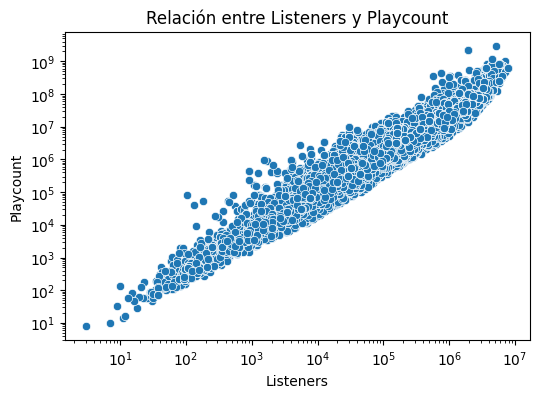

In [ ]:
plt.figure(figsize=(6, 4)) #Relación entre Listeners y Playcount
sns.scatterplot(x='listeners', y='playcount', data=api_df)
plt.title("Relación entre Listeners y Playcount")
plt.xlabel("Listeners")
plt.ylabel("Playcount")
plt.xscale("log")
plt.yscale("log")
plt.show()